In [50]:
%config Autocompleter.use_jedi=False

#### Feature Description:
    - Item_Identifier: Unique product ID
    - Item_Weight: Weight of product
    - Item_Fat_Content: Whether the product is low fat or not 
    - Item_Visibility: The % of total display area of all products in a store allocated to the particular product 
    - Item_Type: The category to which the product belongs 
    - Item_MRP: Maximum Retail Price (list price) of the product 
    - Outlet_Identifier: Unique store ID 
    - Outlet_Establishment_Year: The year in which store was established 
    - Outlet_Size: The size of the store in terms of ground area covered 
    - Outlet_Location_Type: The type of city in which the store is located 
    - Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket 
    - Item_Outlet_Sales: Sales of  the product in the particulat store. This is the outcome variable to be predicted. 


# 0. Importing libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore,boxcox
import seaborn as sns
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [52]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [53]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# 1. Data Inspection
    - Summary of dataset
    - Checking for Null Values, Data Type of Features

In [54]:
train_df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


<h3><u>Observation:</u></h3>
    
#### Irrelevant columns are present which can be removed:
    1. Item_Identifier
    2. Outlet_Identifer (Can be useful in grouping and getting some other informations)
    3. Outlet_Establishment_Year (can be useful to draw some informataion or to do feature engineering)

#### Some columns are categorical which needs to be encoded further:
    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type

In [60]:
print('----------------% of missing Values in train set---------------------------- ')
np.round(train_df.isna().sum()/len(train_df) * 100,2)

----------------% of missing Values in train set---------------------------- 


Item_Identifier               0.00
Item_Weight                  17.17
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.28
Outlet_Location_Type          0.00
Outlet_Type                   0.00
Item_Outlet_Sales             0.00
dtype: float64

In [61]:
print('----------------% of missing Values in test set---------------------------- ')
np.round(test_df.isna().sum()/len(test_df) * 100,2)

----------------% of missing Values in test set---------------------------- 


Item_Identifier               0.00
Item_Weight                  17.18
Item_Fat_Content              0.00
Item_Visibility               0.00
Item_Type                     0.00
Item_MRP                      0.00
Outlet_Identifier             0.00
Outlet_Establishment_Year     0.00
Outlet_Size                  28.27
Outlet_Location_Type          0.00
Outlet_Type                   0.00
dtype: float64

<h3><u>Observation:</u></h3>

#### We can see 2 features have the missing values both in train and test dataset which needs to be handled:
    1. Item_Weight
    2. Outlet_Size

# 2. Data Cleaning
    - Handling Missing Data
    - Removing redundant and duplicate data
    - Handling untidy dataset etc

## 2.1 Handling Missing Data

#### Features with missing values:
    1. Item_Weight
    2. Outlet_Size
    
#### Techniques to handle missing values:
    1. Impute with (Mean, Median) -- good for continous feature
    2. Frequency based imputation (Mode)       -- good for categorical feature
    3. Deleting the NaN rows
    4. imputation based on predictions
    5. Regression Imputation  -- Good if feature is highly correlated
    6. KNN based imputation

In [17]:
wt_miss_val = train_df['Item_Weight'].isna().sum()
print('Total missing value for Item_Weight is {} out of {}'.format(wt_miss_val,len(train_df['Item_Weight'])))

Total missing value for Item_Weight is 1463 out of 8523


In [18]:
size_miss_val = train_df['Outlet_Size'].isna().sum()
print('Total missing value for Outlet_Size is {} out of {}'.format(size_miss_val,len(train_df['Outlet_Size'])))

Total missing value for Outlet_Size is 2410 out of 8523


<AxesSubplot:xlabel='Item_Weight'>

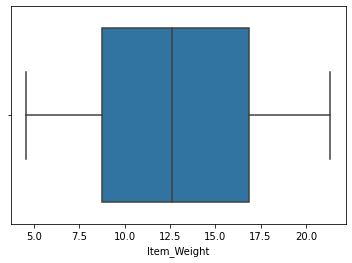

In [19]:
sns.boxplot(train_df['Item_Weight'])

It seems like outlier is not present in this feature so, we can replace the missing values with <b>mean</b> imputation.

In [20]:
# imputing Missing Value for Item_Weight with Mean
train_df['Item_Weight'].fillna(train_df['Item_Weight'].mean(),inplace=True)
test_df['Item_Weight'].fillna(test_df['Item_Weight'].mean(),inplace=True)

In [21]:
# imputing missing value for Outlet_Size based on frequency -- Medium here
print(train_df['Outlet_Size'].value_counts())

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


In [22]:
train_df['Outlet_Size'].fillna(train_df['Outlet_Size'].mode()[0],inplace=True)
test_df['Outlet_Size'].fillna(test_df['Outlet_Size'].mode()[0],inplace=True)

## 2.2 Removing redundant and duplicate data

#### Feature having duplicate data values:
    - Item_Fat_Content

In [38]:
# Get all categorical features
[x for x in train_df.select_dtypes('object').columns]

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [42]:
train_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [23]:
train_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

#### We can convert these multiple duplicate values to single as they denotes the same meaning
    - low fat, LF -> Low Fat & reg -> Regular

In [24]:
train_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
test_df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True)
print(train_df['Item_Fat_Content'].value_counts())

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


# 3. EDA

    - Finding Correlations
    - Checking For multicolinearity
    - Univariate, Bivariate  Multivariate Analysis
    - Understanding about each and every features/columns/variables

## 3.1 Checking Correlation & Multicolinearity

<AxesSubplot:>

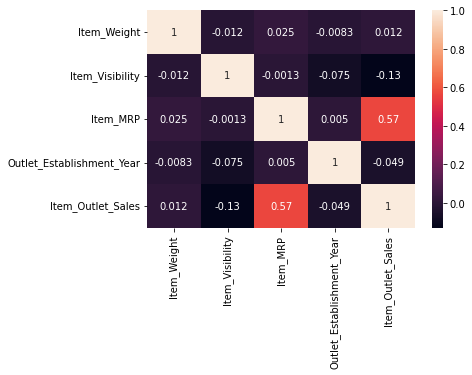

In [44]:
sns.heatmap(train_df.corr(),annot=True)

                        (Fig.- Correlation Heatmap for train data)

#### From this correlation heatmap it can be infered that there is no multicolinearity present.

In [456]:
# sns.pairplot(train_df,hue='Outlet_Type')

#### Some features are skewed which needs to be transformed:
    1. Item_Outlet_Sales (right skewed)
    2. Item_Visibility (right skewed)

#### From this diagram it can be inferred that:
    1. Overall Sales from all outlets  -> Supermarket Type1 > Supermarket Type3  > Grocery Store > Supermarket Type2
    2. Overall sales 
    3. Less sales from grocery store
    4. Outlet Establishments (earlier to later) => Supermarket Type3 -> Supermarket Type1 -> Grocery Store -> 
       Supermarket Type2
    

In [457]:
sales_skewness = train_df['Item_Outlet_Sales'].skew()
visibility_skewness = train_df['Item_Visibility'].skew()
print('Skewness for Item_Outlet_Sales is {} and for Item_Visibility is {}'.format(sales_skewness,visibility_skewness))

Skewness for Item_Outlet_Sales is 1.1775306028542796 and for Item_Visibility is 1.1670905496918396


#### From this it seems like these 2 features are highly skewed (>1), which can lead to unreliable results. So we need to transform it using either of these methods:
    1. Log transform (most preferred) -- We are going to use this over here
    2. Sqrt transform (generally less preferred)
    3. box-cox transform

In [458]:
# Applying log transform to both skewed feature
train_df['Log_Item_Visibility'] = np.sqrt(train_df['Item_Visibility'])
train_df['Log_Item_Outlet_Sales'] = np.log(train_df['Item_Outlet_Sales'])

# train_df.drop(columns=['Item_Visibility','Item_Outlet_Sales'],axis=1,inplace=True)

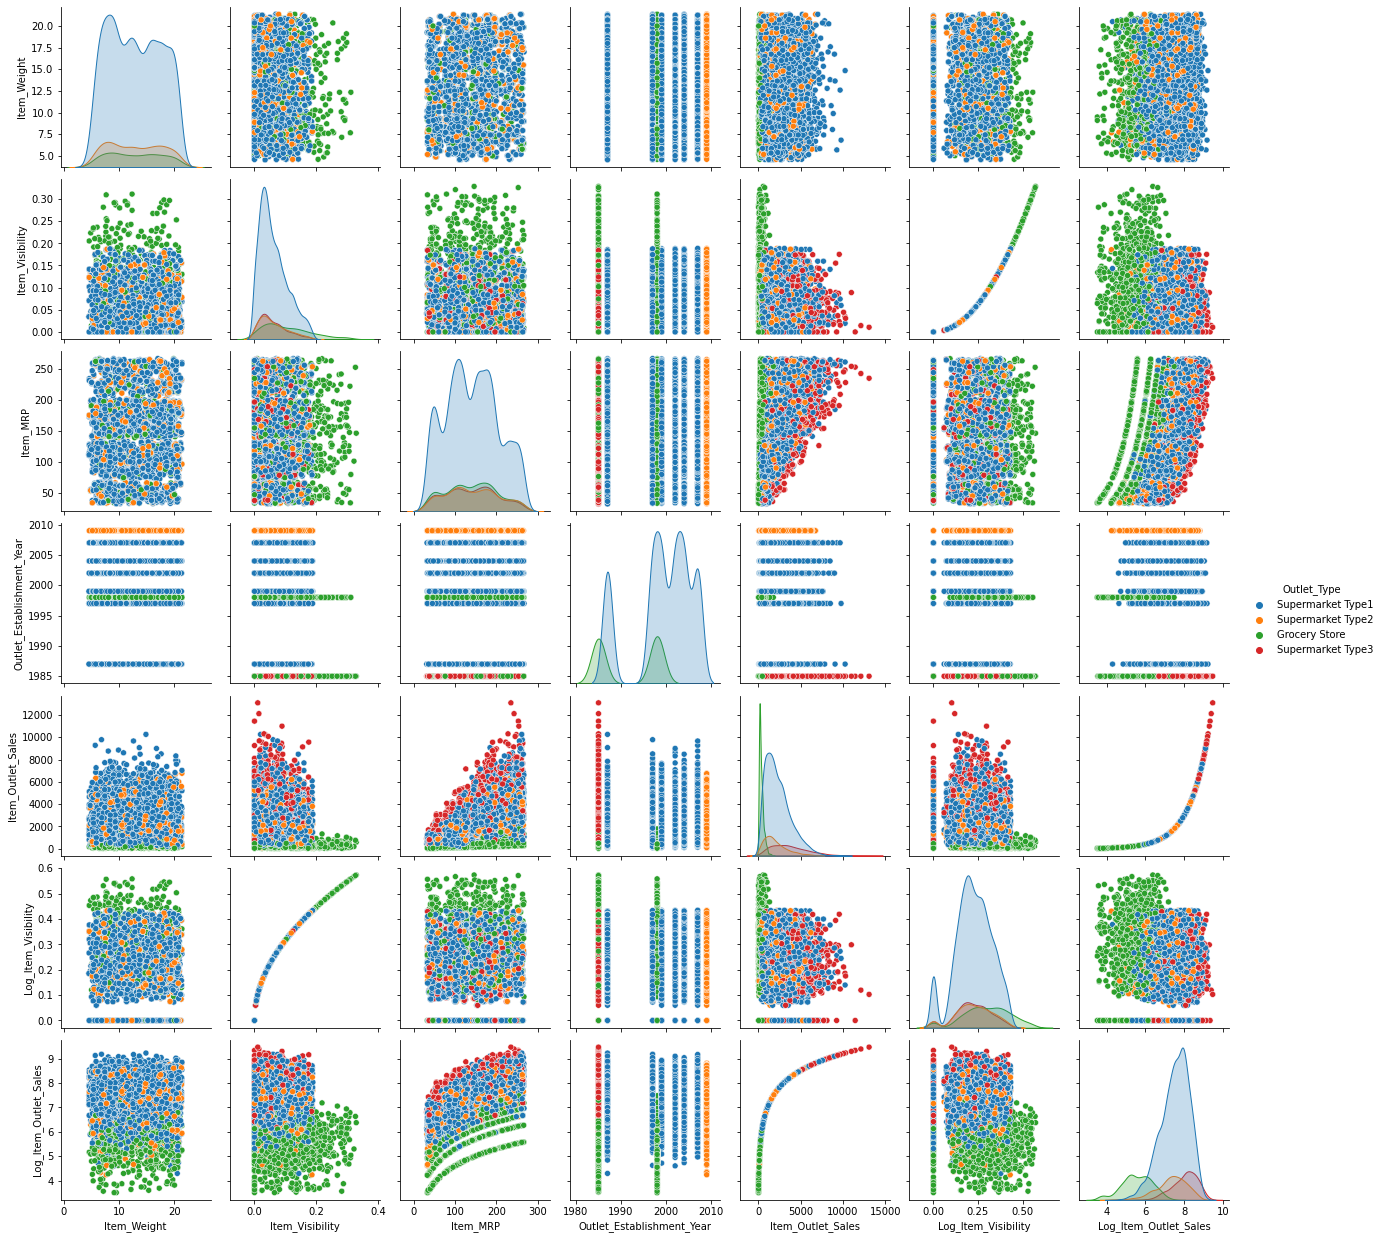

In [459]:
sns.pairplot(train_df,hue='Outlet_Type')

#### After transforming the skewed data it can be inferred that:
    1. There is a positive correlation between MRP and sales.

<AxesSubplot:>

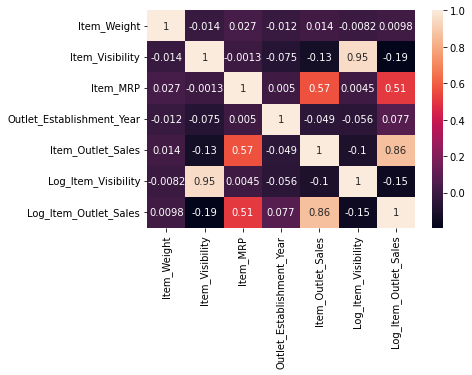

In [460]:
sns.heatmap(train_df.corr(),annot=True)

<center><b>Correlation after feature transformation</b></center>

## 3.2 Univariate Analysis

<AxesSubplot:xlabel='Item_MRP', ylabel='Log_Item_Outlet_Sales'>

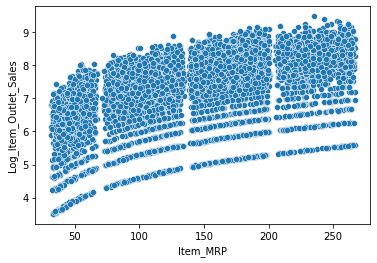

In [461]:
sns.scatterplot(x=train_df['Item_MRP'],y=train_df['Log_Item_Outlet_Sales'])

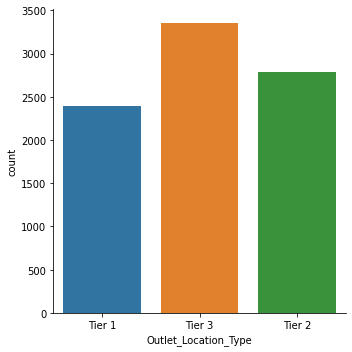

In [462]:
sns.catplot('Outlet_Location_Type',data=train_df,kind='count')

1. More no. of outlet in Tier 3 cities

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

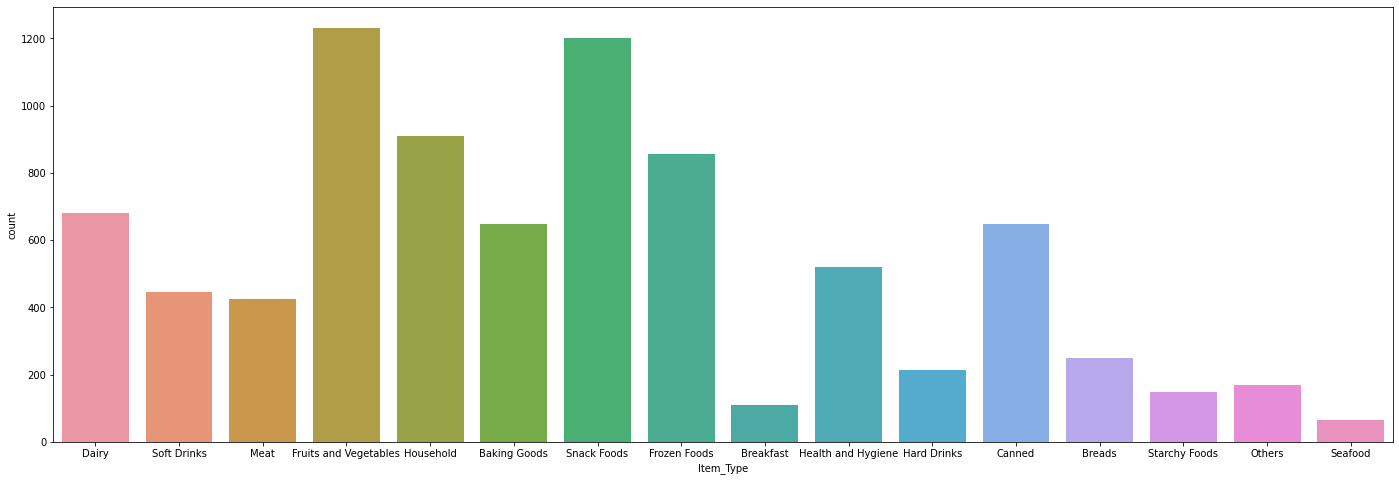

In [463]:
fig,ax = plt.subplots(figsize=(24,8))
sns.countplot(train_df['Item_Type'],ax=ax)

1. Fruits & vegetables are purchased more than others as it is of daily use.
2. Snack Foods also has high sales

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

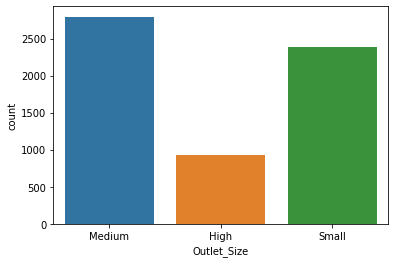

In [464]:
sns.countplot(train_df['Outlet_Size'])

1. Maximum outlet are of medium size

## 3.3 Bivariate Analysis

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

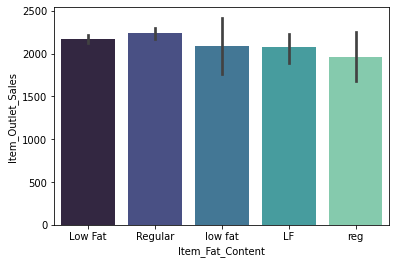

In [465]:
sns.barplot('Item_Fat_Content','Item_Outlet_Sales',data=train_df,palette='mako')

In [393]:
train_df.groupby(by='Outlet_Type')[['Log_Item_Outlet_Sales']].mean()

,Log_Item_Outlet_Sales
Outlet_Type,
Grocery Store,5.545877
Supermarket Type1,7.508524
Supermarket Type2,7.331149
Supermarket Type3,8.025545


#### Outlet Type Vs Avg Sales

In [394]:
train_df.groupby(by='Outlet_Size')[['Log_Item_Outlet_Sales']].mean()

,Log_Item_Outlet_Sales
Outlet_Size,
High,7.475141
Medium,7.629773
Small,7.098222


#### Outlet Size Vs Avg Sales

In [395]:
train_df.groupby(by='Outlet_Location_Type')[['Log_Item_Outlet_Sales']].mean()

,Log_Item_Outlet_Sales
Outlet_Location_Type,
Tier 1,7.081808
Tier 2,7.515595
Tier 3,7.267499


#### Outlet Location Type Vs Avg Sales

# 4. Feature Engineering

    - Handling Outliers
    - Handling irrelevant columns
    - Feature Encoding (handling categorical data)
    - Feature Generation
    - Selecting top/important features

## 4.1 Handling Outliers

#### Ways to treat outliers:
    1. Trimming/removing the outlier
    2. Quantile based flooring and capping
    3. Mean/Median imputation

## 4.2 Feature Encoding


#### Feature that needs to be encoded:

    1. Item_Fat_Content
    2. Item_Type
    3. Outlet_Size
    4. Outlet_Location_Type
    5. Outlet_Type 
    
#### Feature Encoding Techniques:
    1. Binary Encoding -> Item_Fat_Content
    2. Ordinal Encoding -> Outlet_Size, Outlet_Location_Type
    3. Nominal Encoding -> Outlet_Type, Item_Type
    4. Frequency Encoding
    
**  Item_Type is having large unique values

#### For Item_Type we will try grouping up some of the values to reduce unique values count:
    1. Drinks -> Soft Drinks, Hard Drinks
    2. Baking Goods -> Breads
    3. Meat -> Seafood


In [410]:
train_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)
test_df['Item_Type'].replace({'Soft Drinks':'Drinks','Hard Drinks':'Drinks','Breads':'Baking Goods','Seafood':'Meat'},inplace=True)

In [411]:
#Binary Encoding

train_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)
test_df['Item_Fat_Content'].replace({'Low Fat':0,'Regular':1},inplace=True)

In [412]:
#One_hot encoding nominal variables

def one_hot(df,columns,prefixes):
    df = df.copy()
    for column,prefix in zip(columns,prefixes):
        dummies = pd.get_dummies(df[column],prefix=prefix,drop_first=True)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)
    return df

In [413]:
nominal_features = ['Outlet_Type','Item_Type']
prefixes = ['out_type','item_type']

train_df = one_hot(train_df,nominal_features,prefixes)
test_df = one_hot(test_df,nominal_features,prefixes)

In [414]:
#Ordinal Encoding

def ord_enc(df,col,ord_var):
    df = df.copy()
    df[col].replace(ord_var,inplace=True)
    return df

In [415]:
#Encoding Ordinal columns

outlet_size_ord = {'Small':0,'Medium':1,'High':2}
out_loc_ord = {'Tier 1':2,'Tier 2':1,'Tier 3':0}

train_df = ord_enc(train_df,'Outlet_Size',outlet_size_ord)
test_df = ord_enc(test_df,'Outlet_Size',outlet_size_ord)

train_df = ord_enc(train_df,'Outlet_Location_Type',out_loc_ord)
test_df = ord_enc(test_df,'Outlet_Location_Type',out_loc_ord)

## 4.3 Removing irrelevant columns

#### Irrelevant Columns in this dataset are: 
    1. Item_Identifier
    2. Outlet_Identifier

In [416]:
train_df.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)
test_df.drop(columns=['Item_Identifier','Outlet_Identifier'],axis=1,inplace=True)

In [417]:
cat_feature_count = len(train_df.select_dtypes('object').count())
print('Total Categorical Features present : {}'.format(cat_feature_count))

Total Categorical Features present : 0


## 4.4 Feature Generation

In [424]:
# Deriving new column called Years_Since_Established from Establishment Year

train_df['Years_Since_Established'] = train_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x) 
test_df['Years_Since_Established'] = test_df['Outlet_Establishment_Year'].apply(lambda x: 2021 - x)

# 5. Splitting & Training Model

    1. Scaling
    2. Splitting
    3. Training

In [425]:
X = train_df.drop(columns=['Log_Item_Outlet_Sales'],axis=1)
y = train_df['Log_Item_Outlet_Sales']

In [426]:
trainX,testX,trainY,testY = train_test_split(X,y,random_state=42,test_size=0.25)

In [427]:
# trainX['Log_Item_Visibility'] = trainX['Log_Item_Visibility']**-1/2
# trainY = np.exp(trainY)
# testX['Log_Item_Visibility'] = testX['Log_Item_Visibility']**-1/2
# testY = np.exp(testY)

In [428]:
model_acc_scores = {}
def predictionResult(testY,pred,model):
    print('--------------------{}------------------'.format(model))
    score = r2_score(testY,pred)
    mae = mean_absolute_error(testY,pred)
    mse = mean_squared_error(testY,pred)
    print('R Squared Score is: {}'.format(score))
    print('Mean Absolute Error is: {}'.format(mae))
    print('Mean Squared Error is: {}'.format(mse))

In [429]:
model_lin_reg = LinearRegression()
cv_score = cross_val_score(model_lin_reg,trainX,trainY,cv=5)
model_lin_reg.fit(trainX,trainY)

pred = model_lin_reg.predict(testX)

predictionResult(testY,pred,'LinearRegression')
print('------CV Score-------')
print(cv_score)

--------------------LinearRegression------------------
R Squared Score is: 0.7242499305137342
Mean Absolute Error is: 0.4212275574271686
Mean Squared Error is: 0.2914116232826209
------CV Score-------
[0.73264671 0.68980591 0.71145463 0.73167227 0.71521099]


In [430]:
model_rf_reg = RandomForestRegressor(n_estimators=350,max_depth=6,random_state=2)
# cv_score = cross_val_score(model_rf_reg,trainX,trainY,cv=5)
model_rf_reg.fit(trainX,trainY)

print('Trining R2 Score: {}'.format(model_rf_reg.score(trainX,trainY)))

pred = model_rf_reg.predict(testX)

predictionResult(testY,pred,'RandomForestRegressor')
# print('------CV Score-------')
# print(cv_score)

Trining R2 Score: 0.7571742210944842
--------------------RandomForestRegressor------------------
R Squared Score is: 0.7406159838754408
Mean Absolute Error is: 0.4049363112597449
Mean Squared Error is: 0.2741160404174915
